# Car Price Prediction Pipeline — Versão Expandida e Detalhada


Este notebook executa todas as etapas principais de um projeto de machine learning:
1. Carregamento e inspeção inicial dos dados
2. Limpeza e tratamento de valores nulos e inconsistentes
3. Engenharia de features
4. Análise exploratória (EDA)
5. Tratamento de outliers
6. Preparação final dos dados
7. Construção do pipeline de machine learning
8. Treinamento e salvamento do modelo
9. Inferência com novo exemplo


In [2]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from feature_engineer import FeatureEngineer

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, FunctionTransformer
)
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV
)
from sklearn.ensemble import (
    RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
)
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt


file_path = 'new_vehicle_all_price.csv'
df = pd.read_csv(file_path)
df = df[df['price'].between(2000, 150000)]
df = df.sample(n=30000, random_state=42).reset_index(drop=True)
print(f"Shape: {df.shape}")
df.head()

Shape: (30000, 10)


,id,price,fuel,year,manufacturer,model,condition,odometer,transmission,paint_color
0,7312389600,5500,gas,1994,chevrolet,suburban 1500,NaN,117426,automatic,NaN
1,7309218331,29900,gas,2014,ford,f-150,excellent,114000,automatic,white
2,7315434677,3900,gas,2004,pontiac,grand am,NaN,149757,automatic,grey
3,7303628106,31800,gas,1996,ford,f-250 xlt 4x4,excellent,25850,automatic,NaN
4,7306950445,2900,gas,2007,ford,taurus,good,226274,automatic,blue


In [3]:
# ## 3) Renomeando colunas para padronizar
rename_dict = {
    'manufacturer': 'make',
    'fuel': 'fuel_type',
    'odometer': 'Kilometer',
    'year': 'year',
    'price': 'Price'
}
df.rename(columns=rename_dict, inplace=True)

# %% [markdown]
# ## 4) Análise e tratamento de valores nulos

# %%
print("\nValores nulos antes do tratamento:")
print(df.isnull().sum())


Valores nulos antes do tratamento:
id                  0
Price               0
fuel_type         176
year                0
make                0
model               0
condition       11284
Kilometer           0
transmission      145
paint_color      8410
dtype: int64


In [4]:
# Preenchendo valores numéricos com a mediana
for col in ['Engine', 'Max Power']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Preenchendo valores categóricos com a moda
for col in ['fuel_type', 'transmission', 'owner']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

print("\nValores nulos após o tratamento:")
print(df.isnull().sum())


Valores nulos após o tratamento:
id                  0
Price               0
fuel_type           0
year                0
make                0
model               0
condition       11284
Kilometer           0
transmission        0
paint_color      8410
dtype: int64



Distribuições de variáveis numéricas:


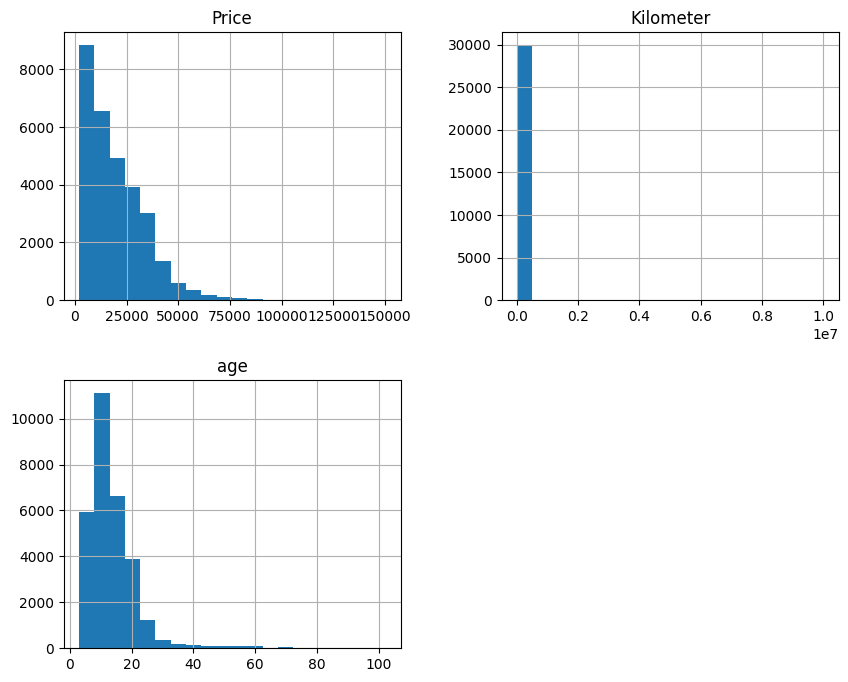

In [5]:
# %% [markdown]
# ## 5) Visualização de distribuições numéricas

# %%
print("\nDistribuições de variáveis numéricas:")
df['age'] = datetime.datetime.now().year - df['year']
df[['Price', 'Kilometer', 'age']].hist(bins=20, figsize=(10, 8))
plt.show()


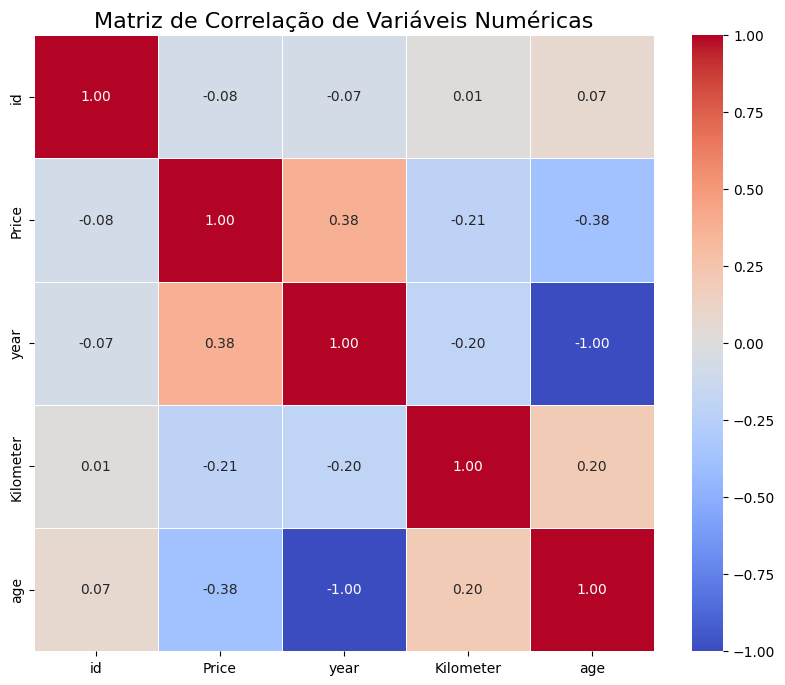

In [6]:
# ## 6) Análise de correlação

# %%
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação de Variáveis Numéricas", fontsize=16)
plt.show()

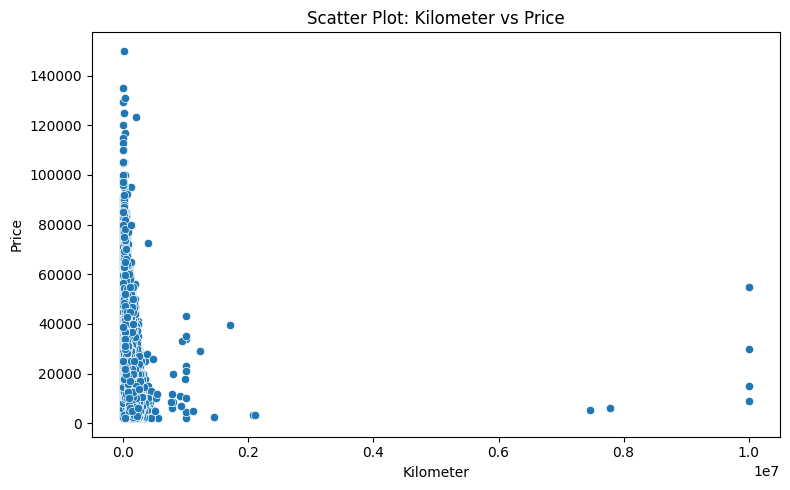

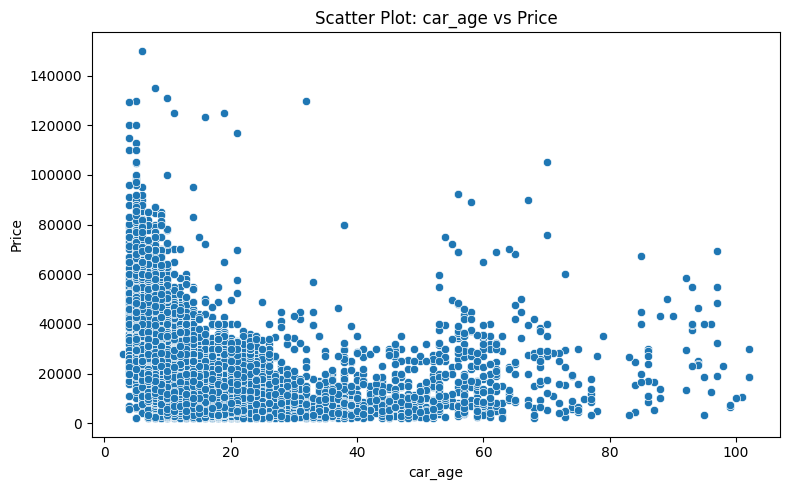

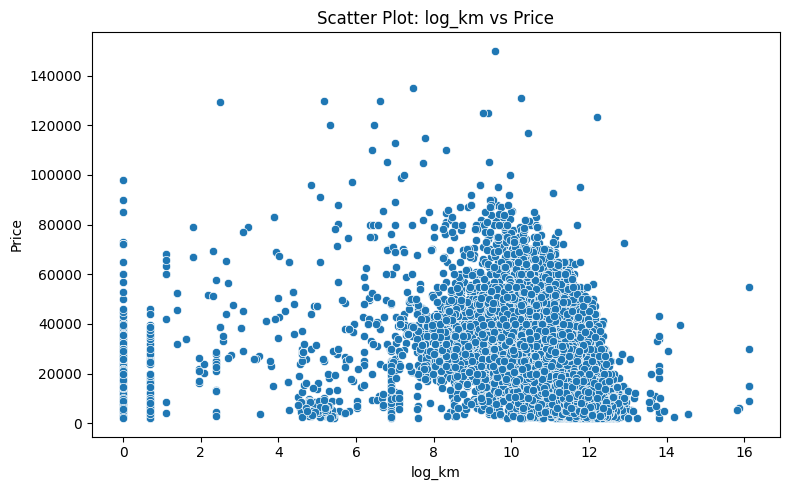

In [7]:
# %% [markdown]
# ## 6.1) Scatter plots para relação entre variáveis numéricas e preço

# %%
df['car_age'] = datetime.datetime.now().year - df['year']
df['log_km'] = np.log1p(df['Kilometer'])
df['price_log'] = np.log1p(df['Price'])

features_to_plot = ['Kilometer', 'car_age', 'log_km']

for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df[feature], y=df['Price'])
    plt.title(f"Scatter Plot: {feature} vs Price")
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.tight_layout()
    plt.show()



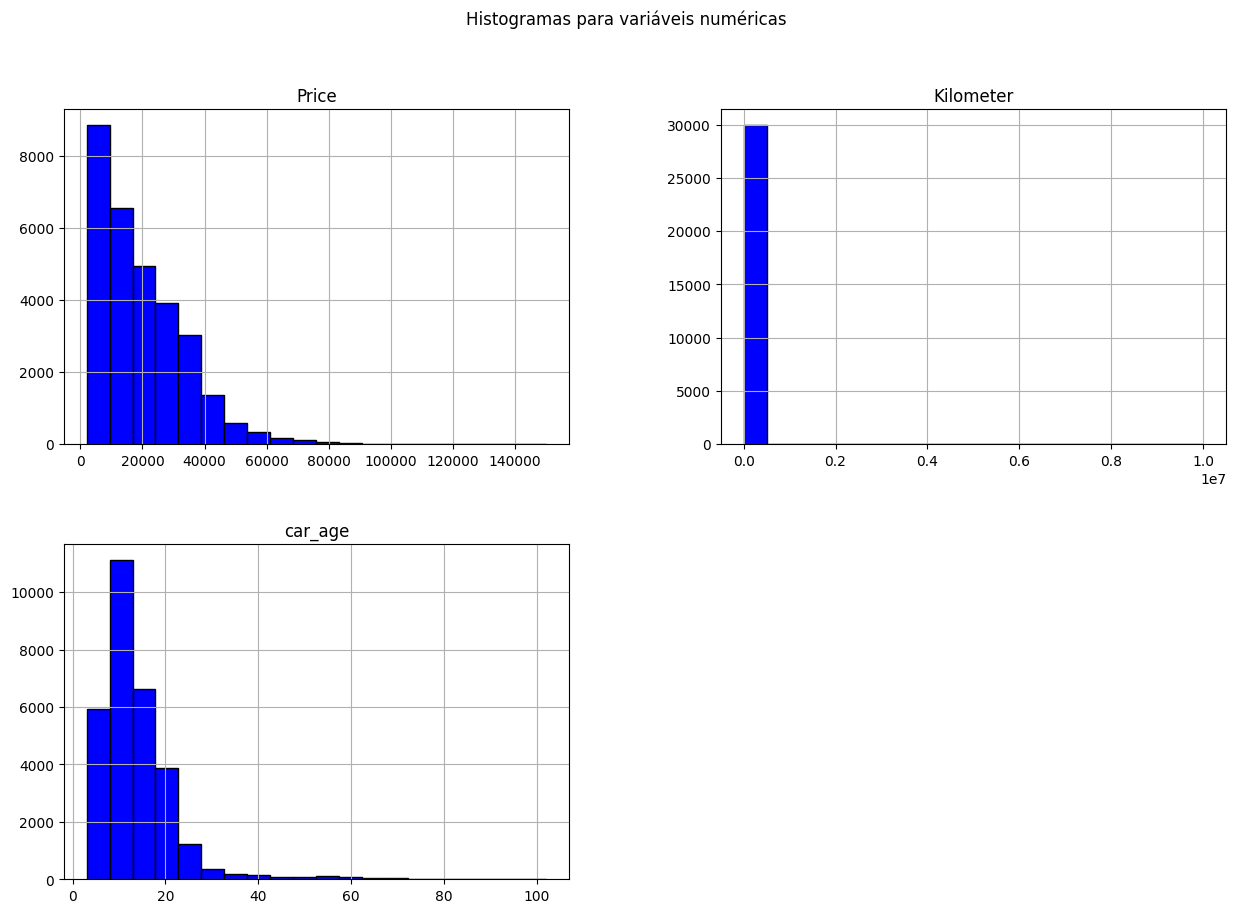

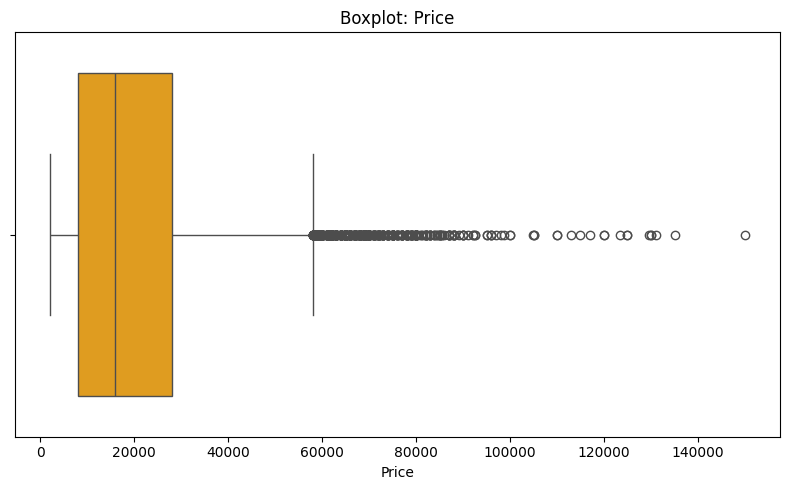

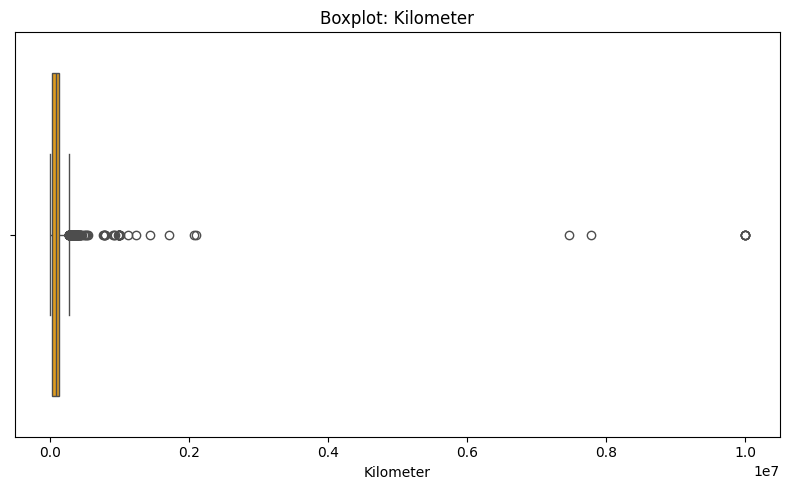

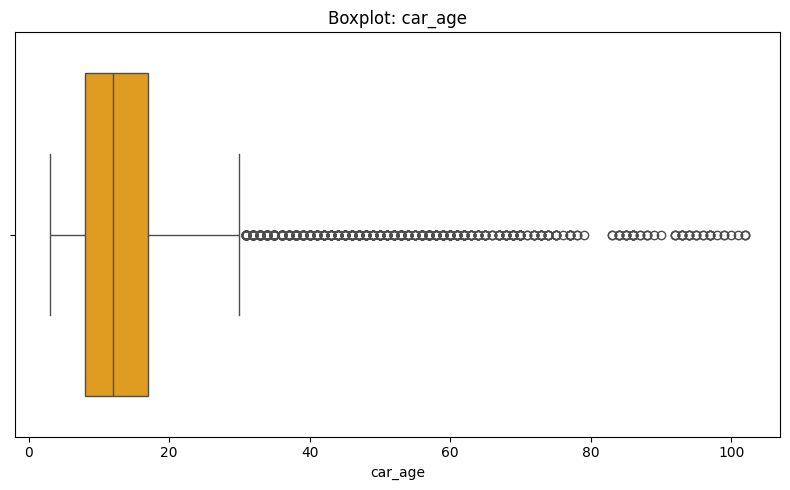

In [8]:
# %% [markdown]
# ## 6.2) Histogramas e boxplots para variáveis numéricas

# %%
# Gera idade do carro, se ainda não existir
if 'car_age' not in df.columns:
    df['car_age'] = datetime.datetime.now().year - df['year']

numerical_features = ['Price', 'Kilometer', 'car_age']
if 'Engine' in df.columns:
    numerical_features.append('Engine')
if 'Max Power' in df.columns:
    numerical_features.append('Max Power')

# Histograma
df[numerical_features].hist(bins=20, figsize=(15, 10), color='blue', edgecolor='black')
plt.suptitle("Histogramas para variáveis numéricas")
plt.show()

# Boxplots para outliers
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[feature], color='orange')
    plt.title(f"Boxplot: {feature}")
    plt.tight_layout()
    plt.show()


In [9]:
# ## 7) Remoção de registros com colunas essenciais nulas

# %%
col_required = ['make', 'model', 'fuel_type', 'transmission', 'Kilometer', 'year', 'Price']
df.dropna(subset=col_required, inplace=True)

In [10]:
# ## 8) Conversão de tipos e remoção de outliers extremos

# %%
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Kilometer'] = pd.to_numeric(df['Kilometer'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df[df['Price'] >= 1000]

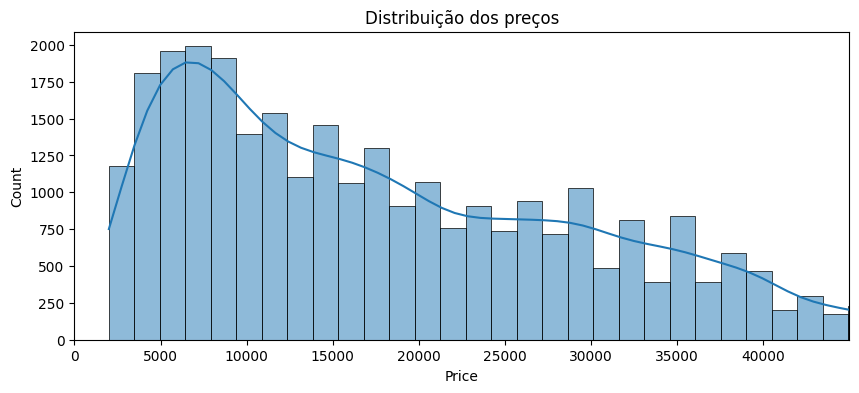

In [11]:
# ## 9) Visualização da distribuição de preços (atualizada)

# %%
plt.figure(figsize=(10, 4))
sns.histplot(df['Price'], bins=100, kde=True)
plt.title("Distribuição dos preços")
plt.xlim(0, df['Price'].quantile(0.95))
plt.show()

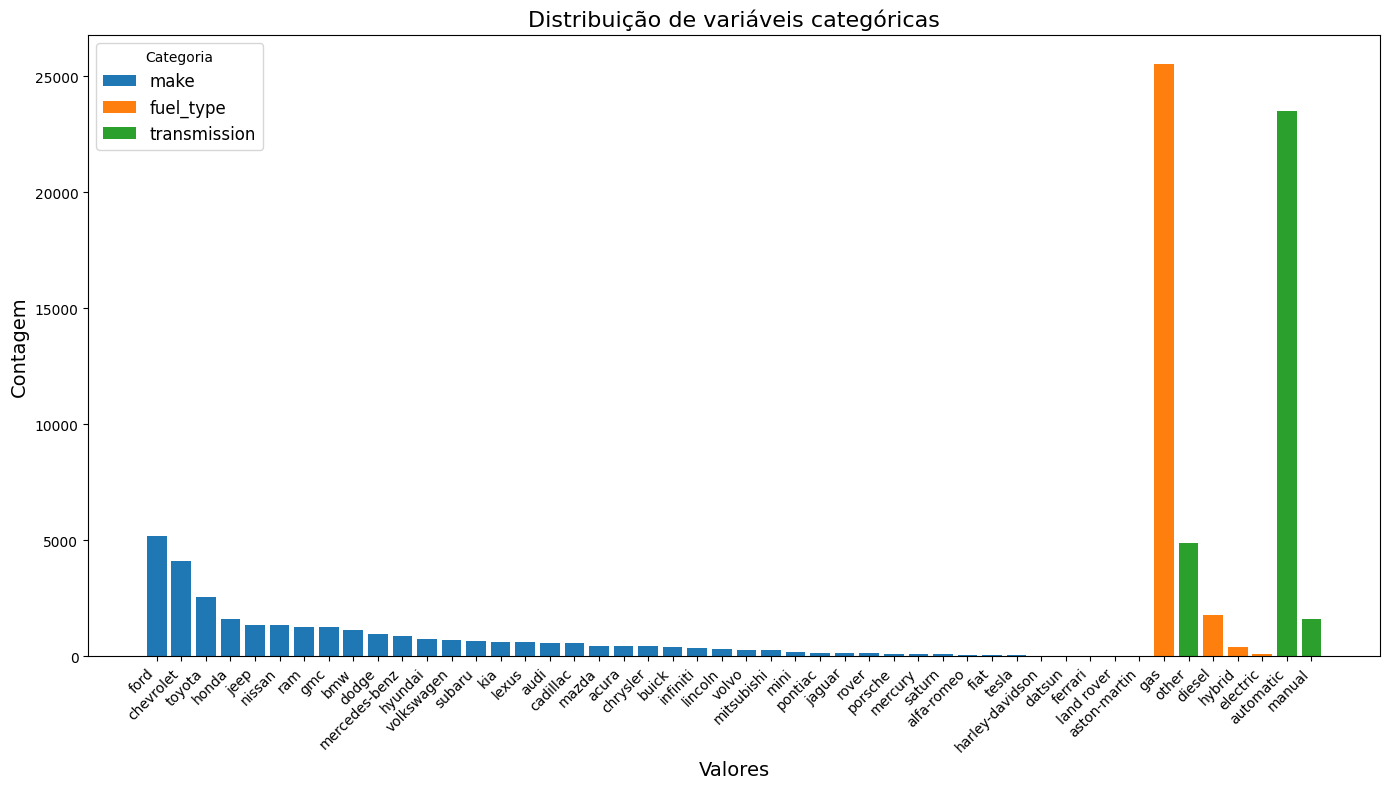

In [12]:
# ## 10) Visualização de variáveis categóricas

# %%
categories = {
    'make': df['make'].value_counts(),
    'fuel_type': df['fuel_type'].value_counts(),
    'transmission': df['transmission'].value_counts()
}

combined_df = pd.concat(categories).reset_index()
combined_df.columns = ['Category', 'Value', 'Count']

plt.figure(figsize=(14, 8))
for category in combined_df['Category'].unique():
    cat_data = combined_df[combined_df['Category'] == category]
    plt.bar(cat_data['Value'], cat_data['Count'], label=category)

plt.title("Distribuição de variáveis categóricas", fontsize=16)
plt.xlabel("Valores", fontsize=14)
plt.ylabel("Contagem", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Categoria", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Feature Engineering + Transformações
def add_features(X):
    X = X.copy()
    X['age'] = 2025 - X['year']
    X['mileage_per_year'] = X['Kilometer'] / X['age'].replace(0, 1)
    X['is_luxury_brand'] = X['make'].isin(['BMW', 'Audi', 'Mercedes', 'Lexus', 'Porsche']).astype(int)
    return X.drop(columns=['year', 'Kilometer'])

from sklearn.preprocessing import FunctionTransformer
feature_transform = FunctionTransformer(add_features)

# Amostragem e split
sample_df = df.sample(n=30000, random_state=42)
X = sample_df[['make', 'model', 'fuel_type', 'transmission', 'Kilometer', 'year']]
y = np.log1p(sample_df['Price'])
X = feature_transform.transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pré-processamento
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

cat_feats = ['make', 'model', 'fuel_type', 'transmission']
num_feats = ['age', 'mileage_per_year', 'is_luxury_brand']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats)
], sparse_threshold=0.3)

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

rf = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

gb = Pipeline([
    ('prep', preprocessor),
    ('model', HistGradientBoostingRegressor(random_state=42))
])

# Hyperparameter Search
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    'model__n_estimators': randint(150, 500),
    'model__max_depth': [None] + list(range(10, 25, 5)),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5)
}

gb_params = {
    'model__learning_rate': uniform(0.01, 0.19),
    'model__max_iter': randint(150, 600),
    'model__max_depth': randint(4, 10)
}

rf_search = RandomizedSearchCV(rf, rf_params, n_iter=10, cv=3,
                               scoring='neg_root_mean_squared_error',
                               random_state=42, n_jobs=-1, verbose=1)
rf_search.fit(X_train, y_train)

gb_search = RandomizedSearchCV(gb, gb_params, n_iter=10, cv=3,
                               scoring='neg_root_mean_squared_error',
                               random_state=42, n_jobs=-1, verbose=1)
gb_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
best_gb = gb_search.best_estimator_

# Refaz gb pipeline sem função local
gb_no_densify = Pipeline([
    ('prep', preprocessor),
    ('model', HistGradientBoostingRegressor(**best_gb.named_steps['model'].get_params()))
])

# Stack com RidgeCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor

stack = StackingRegressor(
    estimators=[('rf', best_rf), ('hgb', gb_no_densify)],
    final_estimator=RidgeCV(),
    n_jobs=-1
)
stack.fit(X_train, y_train)

# Avaliação
from sklearn.metrics import mean_squared_error, r2_score
test_preds = stack.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))
r2_test = r2_score(y_test, test_preds)

print("Random Forest Best Params:", rf_search.best_params_)
print("HistGradientBoosting Best Params:", gb_search.best_params_)
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test R²: {r2_test:.3f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In this project, two regression models—Linear Regression and Random Forest—were evaluated for predicting used car prices. While Linear Regression provided a useful baseline, it struggled to capture the complexity and non-linear relationships present in the data, resulting in an RMSE of 0.5471 and R² of 0.5998. In contrast, the Random Forest model achieved a lower RMSE of 0.5147 and a higher R² of 0.6458, indicating better predictive accuracy and a stronger ability to explain the variance in car prices. These results suggest that Random Forest is better suited for this task, given its capacity to model interactions and non-linearities effectively.

In [ ]:
import joblib

# Cria pipeline completa com feature engineering + stack
final_pipeline = Pipeline([
    ('feat_eng', feature_transform),
    ('model', stack)
])

joblib.dump(final_pipeline, 'car_price_stacked_pipeline.pkl', protocol=4)
print("Modelo empilhado salvo com sucesso!")


In [ ]:
import joblib
import numpy as np
import pandas as pd

sample = {
    'make': 'BMW',
    'model': 'i3',
    'fuel_type': 'electric',
    'transmission': 'automatic',
    'year': 2015,
    'Kilometer': 80000
}
df_s = pd.DataFrame([sample])

# Carrega pipeline completo
loaded_model = joblib.load('car_price_stacked_pipeline.pkl')

# Predição
log_pred = loaded_model.predict(df_s)[0]
price_pred = np.expm1(log_pred)
print(f"Preço previsto: R$ {price_pred:,.2f}")


In [ ]:
# Extrai nomes das features transformadas do best_rf
preproc = best_rf.named_steps['prep']
cat_names = list(preproc.named_transformers_['cat'].get_feature_names_out(cat_feats))
feature_names = num_feats + cat_names

# Importância das features no Random Forest
importances = best_rf.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Exibe top 10
print("Top 10 features:\n", feat_imp.head(10))

# Plot
plt.figure(figsize=(8,5))
feat_imp.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.ylabel('Importância')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
